In [249]:
import h5py
import tensorflow as tf
import numpy as np
import math
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models, Model, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda
from tensorflow.keras.utils import plot_model
import matplotlib.image as mpimg

In [251]:
hdf5_file = "energy_data.h5"
test_hdf5_file = "angle_data.h5"

In [253]:
# Define the generator function
def hdf5_generator(hdf5_file):
    with h5py.File(hdf5_file, 'r') as f:
        data = f['data']  # Assuming data is (x, y, z) for each sample in the file
        labels = f['labels']
        num_samples = data.shape[0]  # The number of samples in the dataset

        for i in range(num_samples):
            image = data[i]  # Shape of image: (x, y, z)
            label = labels[i]  # Shape of label, depending on your task

            # Add color channel dimension to the image (shape becomes (x, y, z, 1))
            image = np.expand_dims(image, axis=-1)  # Adding the color channel (1 for grayscale)
            
            # Yield the image and label
            yield image, label

# Define the dataset pipeline
dataset = tf.data.Dataset.from_generator(
    hdf5_generator,
    args=[hdf5_file],  # Provide the path to your HDF5 file here
    output_signature=(
        tf.TensorSpec(shape=(20, 110, 11, 1), dtype=tf.float32),  # Shape with added color channel
        tf.TensorSpec(shape=(), dtype=tf.int16)  # Label shape
    )
)

print("Train data loaded")

def test_hdf5_generator(hdf5_file):
    with h5py.File(test_hdf5_file, 'r') as f:
        data = f['data']  # Assuming data is (x, y, z) for each sample in the file
        labels = f['labels']
        num_samples = data.shape[0]  # The number of samples in the dataset

        for i in range(num_samples):
            image = data[i]  # Shape of image: (x, y, z)
            label = labels[i]  # Shape of label, depending on your task

            # Add color channel dimension to the image (shape becomes (x, y, z, 1))
            image = np.expand_dims(image, axis=-1)  # Adding the color channel (1 for grayscale)
            
            # Yield the image and label
            yield image, label

# Define the dataset pipeline
test_dataset = tf.data.Dataset.from_generator(
    test_hdf5_generator,
    args=[test_hdf5_file],  # Provide the path to your HDF5 file here
    output_signature=(
        tf.TensorSpec(shape=(20, 110, 11, 1), dtype=tf.float32),  # Shape with added color channel
        tf.TensorSpec(shape=(), dtype=tf.int16)  # Label shape
    )
)

# Optimize the pipeline

print("Validation and test data loaded")

Train data loaded
Validation and test data loaded


In [315]:
#Nazwa modelu, jakiej części datasetu chcesz używać
model_name='2CCM[32,32]+E+2D'
p=0.01

In [323]:
with h5py.File(hdf5_file, "r") as hdf:
    dataset_size = len(hdf["data"])  # Or hdf["labels"], if they have the same length
    print(f"Dataset size: {dataset_size}")
train_dataset=dataset.take(int(0.8*dataset_size*p))
train_dataset=train_dataset.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_dataset=test_dataset.take(int(int(0.3*dataset_size*p)))
val_dataset=val_dataset.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_ds=test_dataset.skip(int(int(0.3*dataset_size*p))).take(int(int(0.1*dataset_size*p)))
test_ds=test_ds.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_ds2=dataset.skip(int(0.8*dataset_size*p)).take(int(0.2*dataset_size*p))
test_ds2=test_ds2.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
print("Dane treningowe, walidacyjne i testowe ready")

Dataset size: 450000
Dane treningowe, walidacyjne i testowe ready


In [319]:
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=3,                 # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True   # Restore model weights from the best epoch
)

In [329]:
#Tu zdefiniuj model
input_3d = Input(shape=(20, 110, 11, 1), name='3D_Input')

# 3D CNN Path
x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same')(input_3d) 
x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

x = layers.Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = layers.Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)


# Flatten 3D features
x = layers.Flatten()(x)

summed_tensor = Lambda(lambda t: tf.reduce_sum(t, axis=[1, 2, 3, 4]))(input_3d)  # Sum over spatial dimensions
summed_tensor_expanded = Lambda(lambda t: tf.expand_dims(t, axis=-1))(summed_tensor)  # Expand to (None, 1)

# Ensure shapes are compatible for concatenation
combined = layers.Concatenate(axis=-1)([x, summed_tensor_expanded])  # Concatenate along last axis
fc = layers.Dense(128, activation='relu')(combined)
fc = layers.Dense(64, activation='relu')(fc)

# Output Layer
output = layers.Dense(1, activation='linear')(fc)

# Define the Model
model = Model(inputs=[input_3d], outputs=output)

# Compile the Model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])


In [331]:
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True);

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 3D_Input            │ (None, 20, 110,   │          0 │ -                 │
│ (InputLayer)        │ 11, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_87 (Conv3D)  │ (None, 20, 110,   │        896 │ 3D_Input[0][0]    │
│                     │ 11, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_88 (Conv3D)  │ (None, 20, 110,   │     27,680 │ conv3d_87[0][0]   │
│                     │ 11, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_71    │ (None, 10, 55, 5, │          0 │ conv3d_88[0][0]   │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_89 (Conv3D)  │ (None, 10, 55, 5, │     13,840 │ max_pooling3d_71… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_90 (Conv3D)  │ (None, 10, 55, 5, │      6,928 │ conv3d_89[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_72    │ (None, 5, 27, 2,  │          0 │ conv3d_90[0][0]   │
│ (MaxPooling3D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_40 (Lambda)  │ (None)            │          0 │ 3D_Input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_25          │ (None, 4320)      │          0 │ max_pooling3d_72… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_41 (Lambda)  │ (None, 1)         │          0 │ lambda_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 4321)      │          0 │ flatten_25[0][0], │
│ (Concatenate)       │                   │            │ lambda_41[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_92 (Dense)    │ (None, 128)       │    553,216 │ concatenate_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_93 (Dense)    │ (None, 64)        │      8,256 │ dense_92[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_94 (Dense)    │ (None, 1)         │         65 │ dense_93[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 610,881 (2.33 MB)

 Trainable params: 610,881 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

In [333]:
#Trening
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    shuffle=True,
    epochs=20,                 # Set a high number of epochs; EarlyStopping will stop early
    callbacks=[early_stopping],  # Add EarlyStopping to callbacks
    verbose=1
)
print("Wytrenowane!")

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - loss: 822.8818 - mean_absolute_error: 15.4133 - val_loss: 37.5372 - val_mean_absolute_error: 4.5394
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - loss: 50.1648 - mean_absolute_error: 5.3563 - val_loss: 36.7341 - val_mean_absolute_error: 4.5005
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - loss: 49.4132 - mean_absolute_error: 5.3208 - val_loss: 37.6827 - val_mean_absolute_error: 4.5068
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 110s 979ms/step - loss: 48.0865 - mean_absolute_error: 5.2560 - val_loss: 45.8344 - val_mean_absolute_error: 4.9832
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 110s 978ms/step - loss: 47.0281 - mean_absolute_error: 5.2186 - val_loss: 46.9806 - val_mean_absolute_error: 5.0529
Wytrenowane!


In [335]:
test_loss_ang, test_mae_ang = model.evaluate(test_ds)
print("Kątowe MAE dla sieci:", test_mae_ang)
test_loss_base, test_mae_base = model.evaluate(test_ds2)
print("Bazowe MAE dla sieci:", test_mae_base)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 33.3248 - mean_absolute_error: 4.3385
Kątowe MAE dla sieci: 4.084143161773682
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 52.7927 - mean_absolute_error: 5.5480
Bazowe MAE dla sieci: 5.415343761444092


In [337]:
y_pred=model.predict(test_ds).flatten()
y_true = np.array([label.numpy() for _, label in test_ds]).flatten()
y_pred2=model.predict(test_ds2).flatten()
y_true2 = np.array([label.numpy() for _, label in test_ds2]).flatten()
y_true=np.concatenate((y_true,y_true2),axis=0)
y_pred=np.concatenate((y_pred,y_pred2),axis=0)

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step


Dodaj notkę jeśli chcesz: MAE kątowe i bazowe bardzo rozbiega, trzeba by przetrenować na większej ilości danych


C:\Users\spbki\AppData\Local\Temp\ipykernel_7628\3461982575.py:11: RuntimeWarning: Mean of empty slice.
  mean_error = [error[bin_indices == i].mean() for i in range(1, num_bins)]


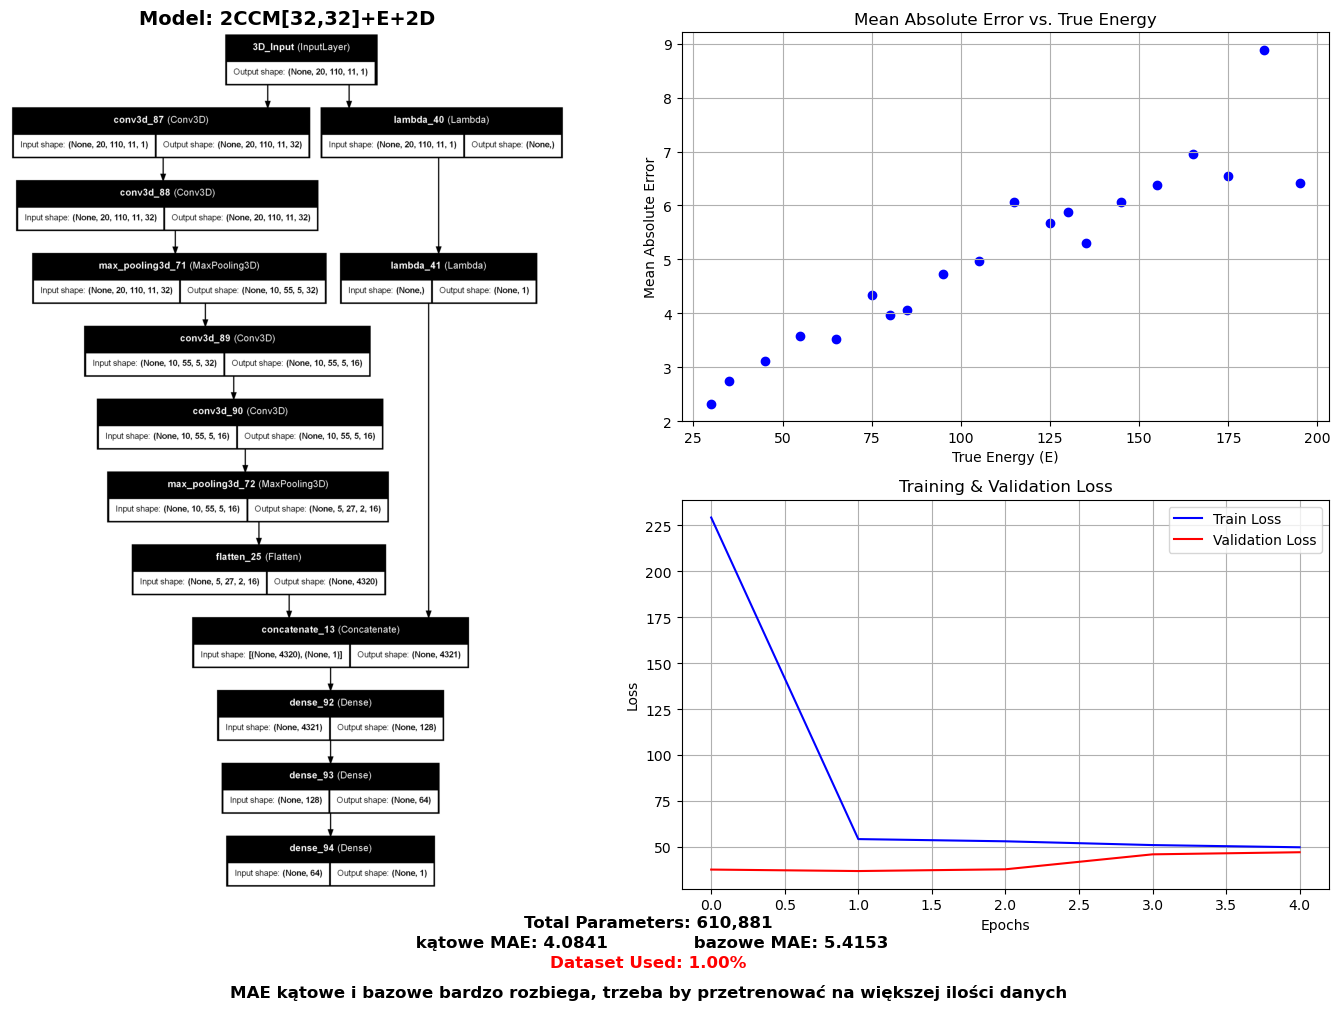

In [355]:
# --- Step 1: Load Model Diagram ---
notes=input("Dodaj notkę jeśli chcesz:")
model_img = mpimg.imread('model.png')
infographic_filename = f"{model_name}_infographic.png"

# --- Step 2: Compute Mean Absolute Error vs. True Energy ---
error = np.abs(y_true - y_pred)
num_bins = 36
bins = np.linspace(y_true.min(), y_true.max(), num_bins)
bin_indices = np.digitize(y_true, bins)
mean_error = [error[bin_indices == i].mean() for i in range(1, num_bins)]

# Total Parameters
total_params = model.count_params()

# --- Step 4: Create Infographic Layout ---
fig = plt.figure(figsize=(14, 10))

# Create a 2x2 grid (but make the first column span two rows)
grid_spec = fig.add_gridspec(2, 2, width_ratios=[1, 1])  # 1st column will span both rows

# --- Column 1 (Left) - Model Diagram (Spanning both rows) ---
ax1 = fig.add_subplot(grid_spec[:, 0])
ax1.imshow(model_img)
ax1.axis('off')  # Hide axes
ax1.set_title(f"Model: {model_name}", fontsize=14, fontweight='bold')

# --- Column 2, Row 1 - MAE vs True Energy ---
ax2 = fig.add_subplot(grid_spec[0, 1])
ax2.scatter(bins[1:], mean_error, marker='o', color='blue')
ax2.set_xlabel("True Energy (E)")
ax2.set_ylabel("Mean Absolute Error")
ax2.set_title("Mean Absolute Error vs. True Energy", fontsize=12)
ax2.grid(True)

# --- Column 2, Row 2 - Training & Validation Loss ---
ax3 = fig.add_subplot(grid_spec[1, 1])
ax3.plot(history.history['loss'], label='Train Loss', color='blue')
ax3.plot(history.history['val_loss'], label='Validation Loss', color='red')
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Loss")
ax3.set_title("Training & Validation Loss", fontsize=12)
ax3.legend()
ax3.grid(True)

# --- Step 5: Add Captions ---
# Captions for MAE, Dataset percentage, Total Parameters
fig.text(0.4, 0.05, f" kątowe MAE: {test_mae_ang:.4f}", ha='center', fontsize=12, fontweight='bold')
fig.text(0.6, 0.05, f" bazowe MAE: {test_mae_base:.4f}", ha='center', fontsize=12, fontweight='bold')
if p<5:
    fig.text(0.5, 0.03, f"Dataset Used: {100*p:.2f}%", ha='center', fontsize=12, fontweight='bold',color='red')
else:
    fig.text(0.5, 0.03, f"Dataset Used: {100*p:.2f}%", ha='center', fontsize=12, fontweight='bold')
# --- Add Model Summary and Total Parameters ---
fig.text(0.5, 0.07, f"Total Parameters: {total_params:,}", ha='center', fontsize=12, fontweight='bold')
fig.text(0.5, 0, notes, ha='center', fontsize=12, fontweight='bold')
# --- Save or Show Infographic ---
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to fit captions
plt.savefig(infographic_filename, dpi=300)
plt.show()
